In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys

SRC = Path.cwd().parent
if str(SRC) not in sys.path: 
    sys.path.append(str(SRC))

import config as cfg

loading raw data from: D:\Air pollution london\data\raw\pollution\london_air_quality_2010_2025.csv


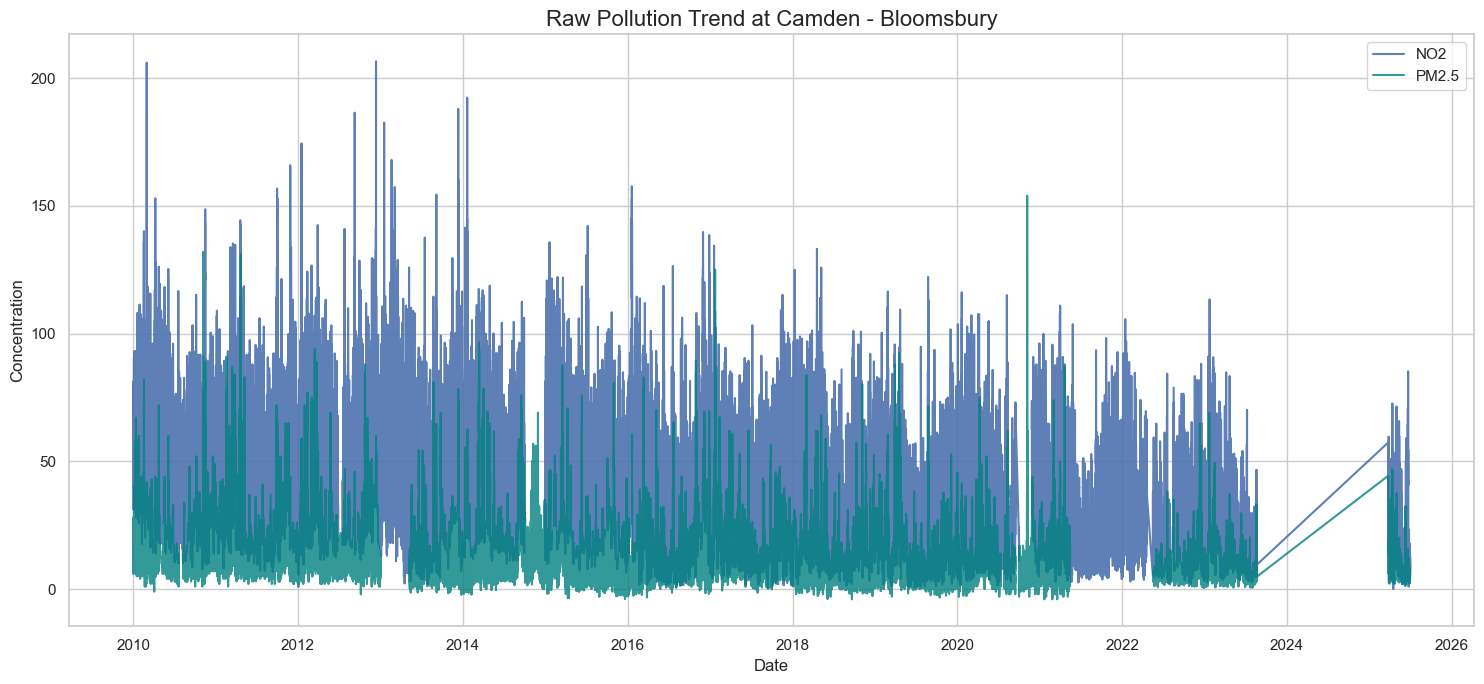

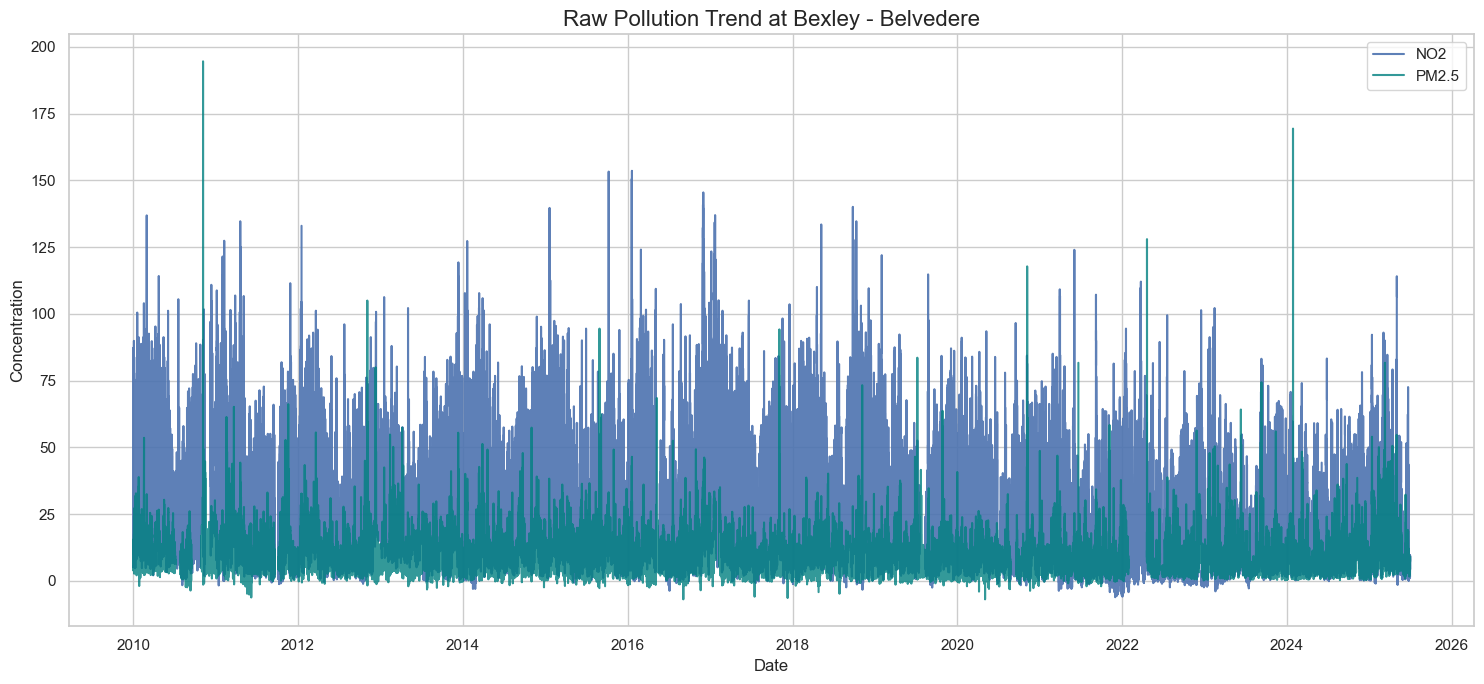

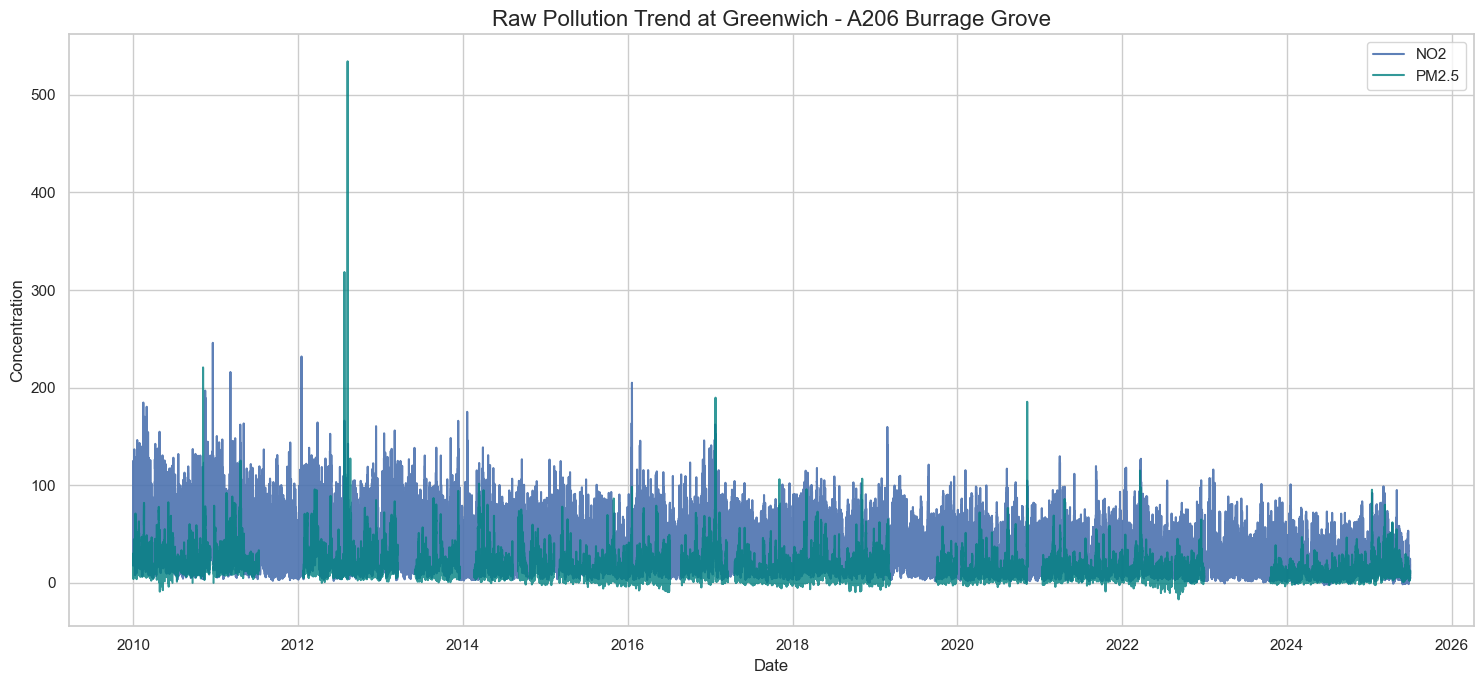

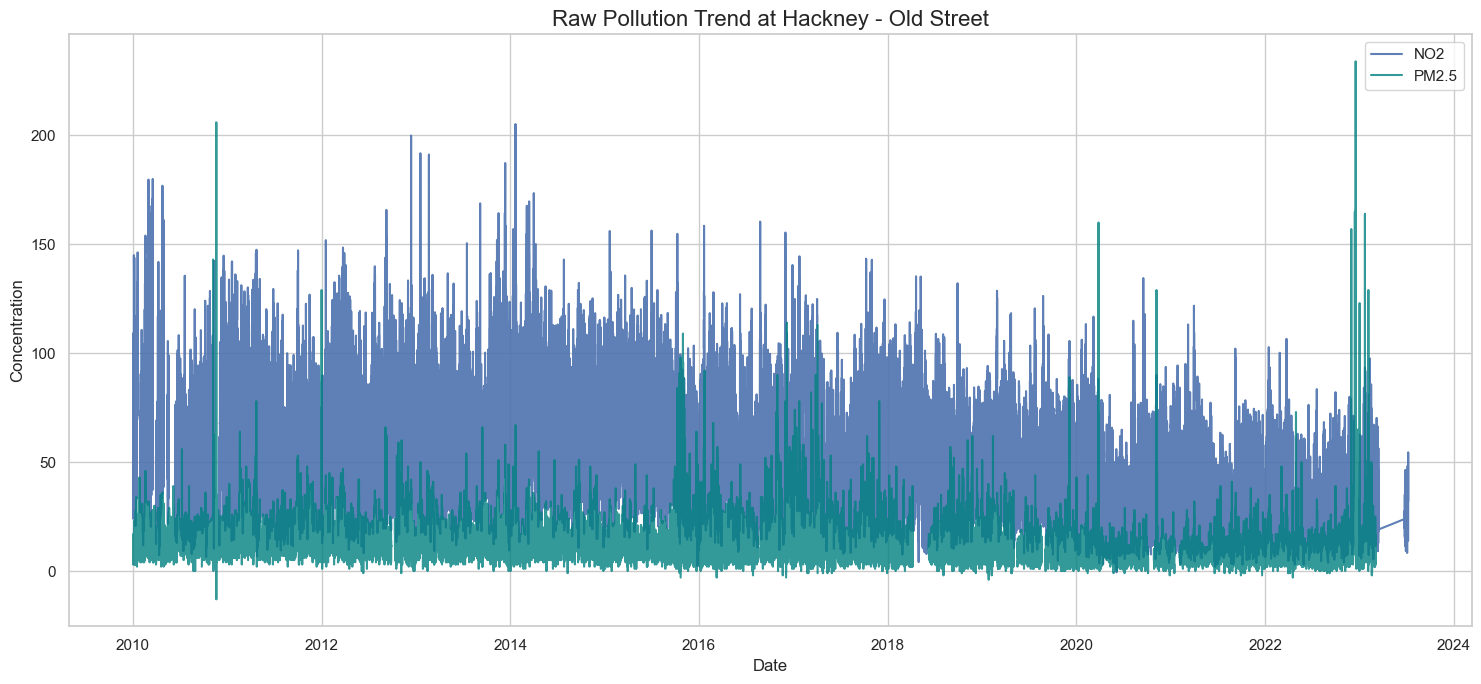

In [59]:
# load original raw data
raw_file_path = cfg.RAW_AQ / "london_air_quality_2010_2025.csv"
print(f"loading raw data from: {raw_file_path}")
df_raw = pd.read_csv(raw_file_path)

# prepare data for plotting
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# to use the name in plot titles later
site_name_map = df_raw.drop_duplicates(subset='site_code').set_index('site_code')['site_name'].to_dict()

# pivot to get pollutants in separate columns
df_raw_pivoted = df_raw.pivot_table(
    index=['timestamp', 'site_code'],
    columns='pollutant',
    values='value'
).reset_index()

# combine the two pm2.5 columns, prioritizing the reference one
if 'FINE' in df_raw_pivoted.columns and 'PM2.5' in df_raw_pivoted.columns:
    df_raw_pivoted['PM2.5'] = df_raw_pivoted['PM2.5'].combine_first(df_raw_pivoted['FINE'])

df_raw_pivoted = df_raw_pivoted.set_index('timestamp')


# plot time series for each site
sites = df_raw_pivoted['site_code'].unique()

for site_code in sites:
    plt.figure()
    
    site_df = df_raw_pivoted[df_raw_pivoted['site_code'] == site_code]
    
    # get the site name from our map
    site_name = site_name_map.get(site_code, site_code) # defaults to code if name not found
    
    # plot both pollutants
    plt.plot(site_df.index, site_df['NO2'], label='NO2', alpha=0.9)
    plt.plot(site_df.index, site_df.get('PM2.5'), label='PM2.5', color='teal', alpha=0.8)
    
    plt.title(f'Raw Pollution Trend at {site_name}', fontsize=16)
    plt.ylabel('Concentration')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [38]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

file_path = cfg.INT_AQ / 'laqn_wide.csv'
df = pd.read_csv(file_path)

# Prepare data for time-series analysis
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Rename columns for simplicity
df.rename(columns={'NO2_final': 'NO2', 'PM2.5_final': 'PM2.5'}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499571 entries, 2010-01-01 00:00:00 to 2023-07-08 06:00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   site_code  499571 non-null  object 
 1   site_name  499571 non-null  object 
 2   latitude   499571 non-null  float64
 3   longitude  499571 non-null  float64
 4   NO2        499571 non-null  float64
 5   PM2.5      499571 non-null  float64
dtypes: float64(4), object(2)
memory usage: 26.7+ MB


In [71]:
df['site_code'].unique()

array(['BL0', 'BX2', 'GN0', 'HK6'], dtype=object)

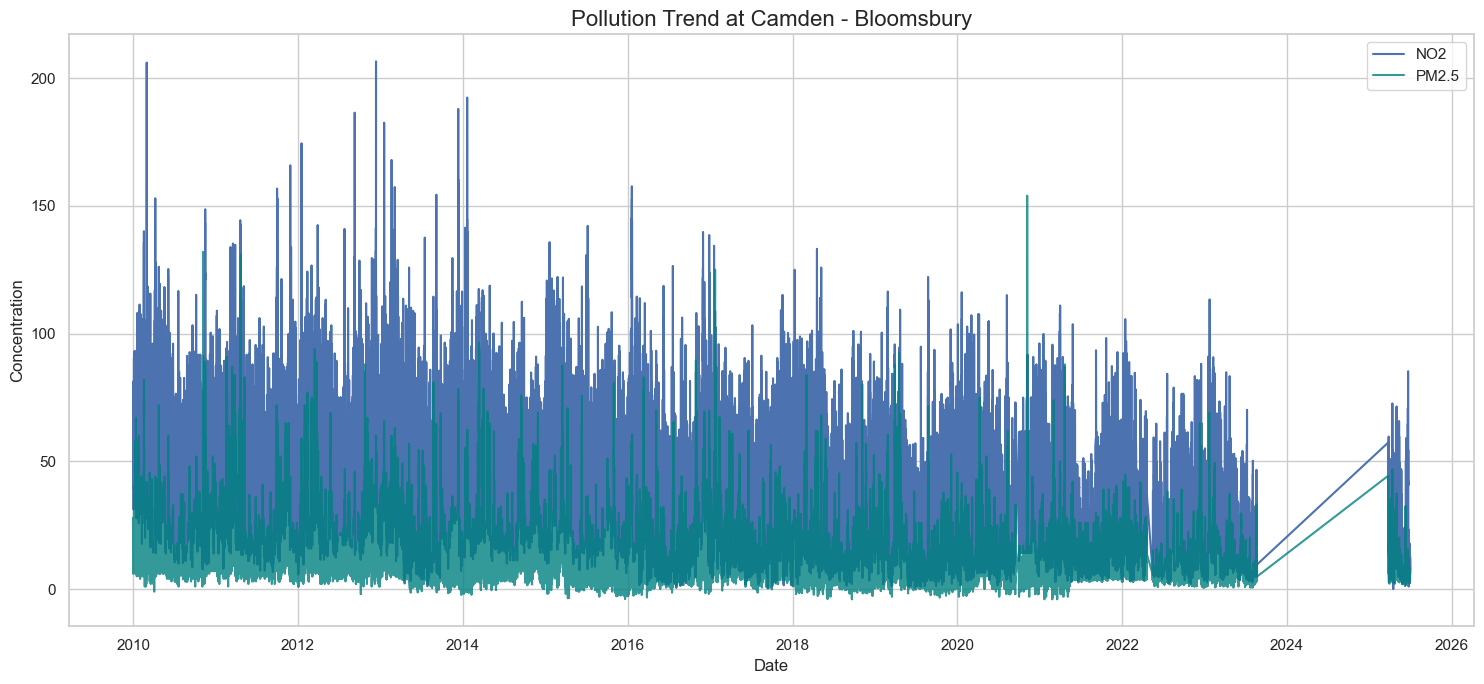

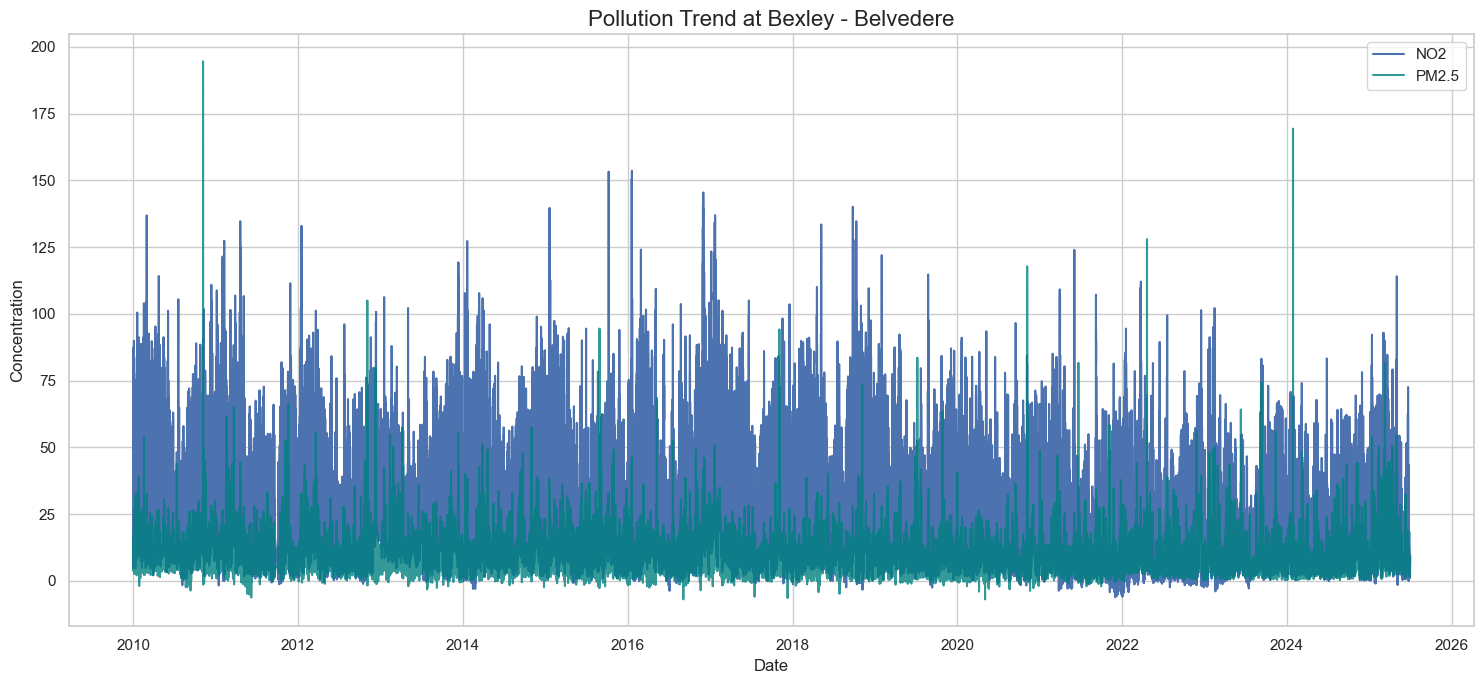

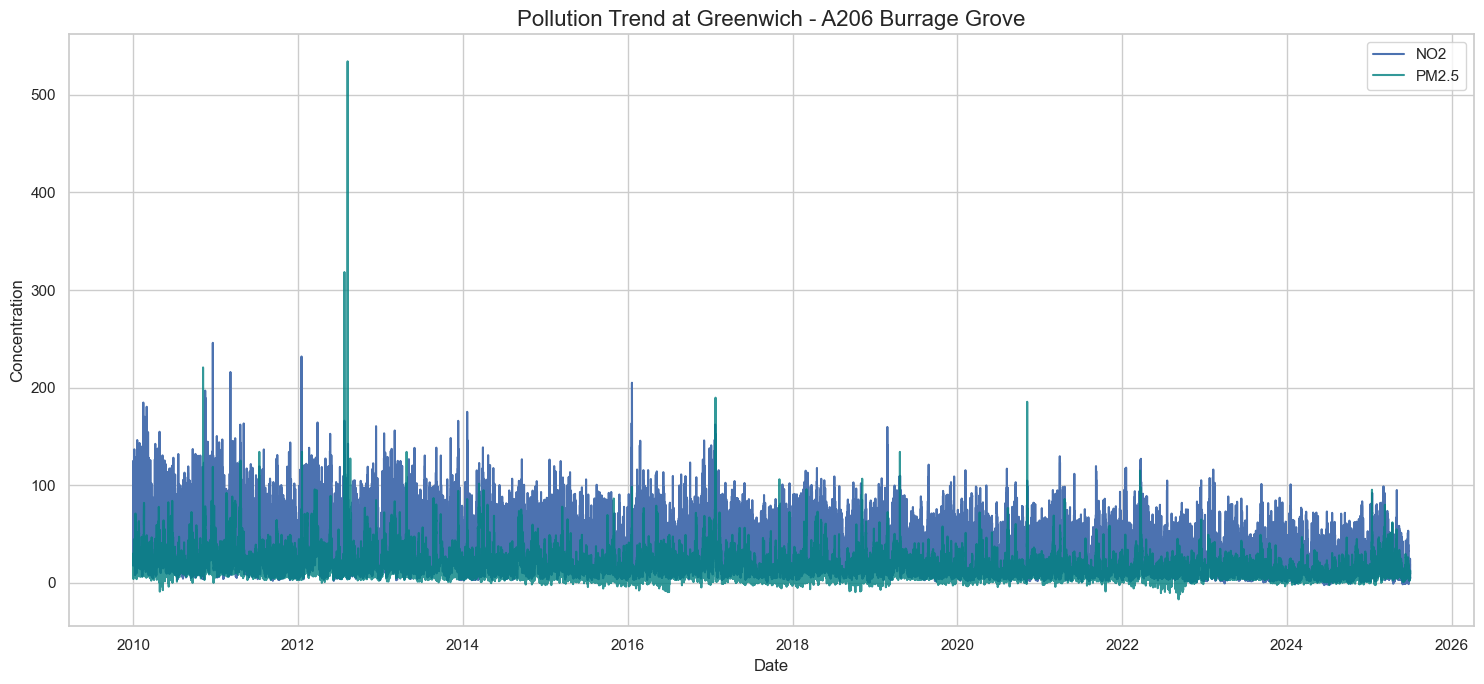

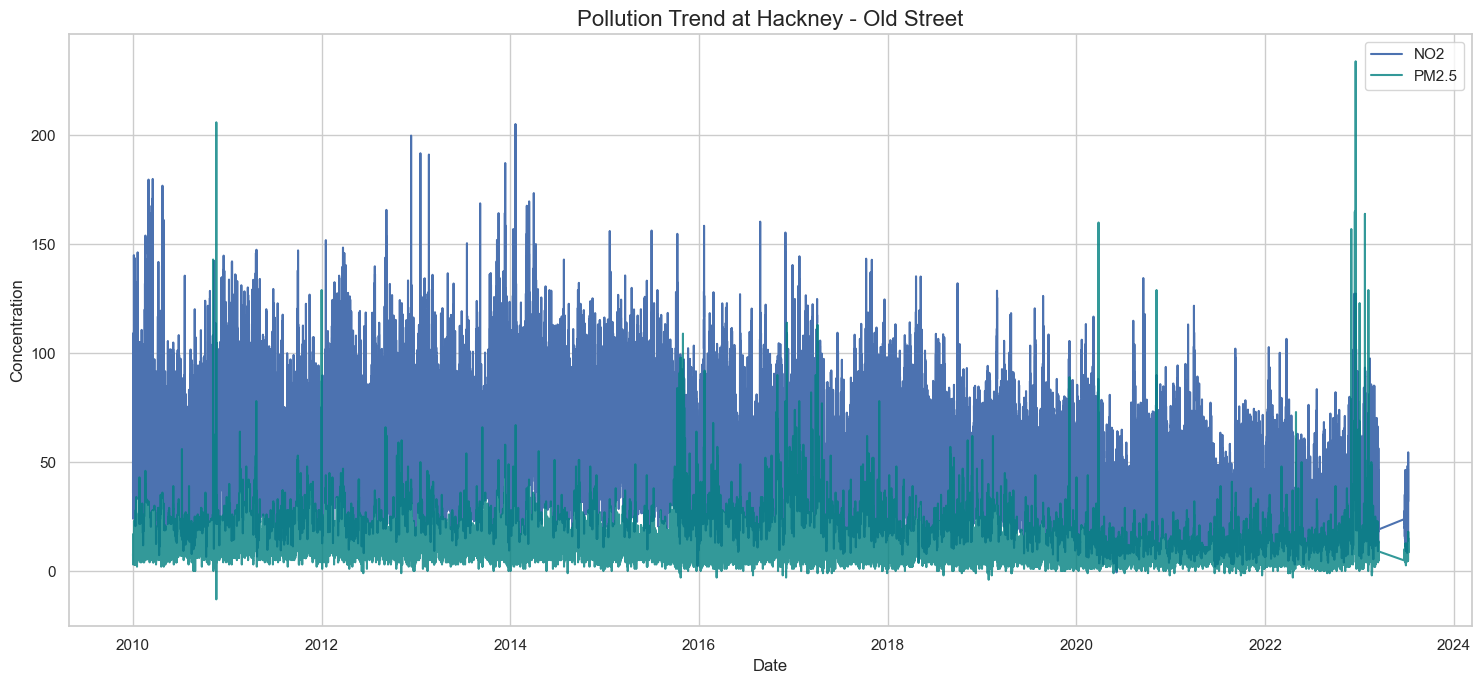

In [39]:
# Site-wise Time Series Plots

# Get a unique list of site names and their codes
sites = df[['site_code', 'site_name']].drop_duplicates().values

for site_code, site_name in sites:
    plt.figure()
    
    # Filter the data for the current site
    site_df = df[df['site_code'] == site_code]
    
    # Plot both pollutants
    plt.plot(site_df.index, site_df['NO2'], label='NO2')
    plt.plot(site_df.index, site_df['PM2.5'], label='PM2.5', color='teal', alpha=0.8)
    
    plt.title(f'Pollution Trend at {site_name}', fontsize=16)
    plt.ylabel('Concentration')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

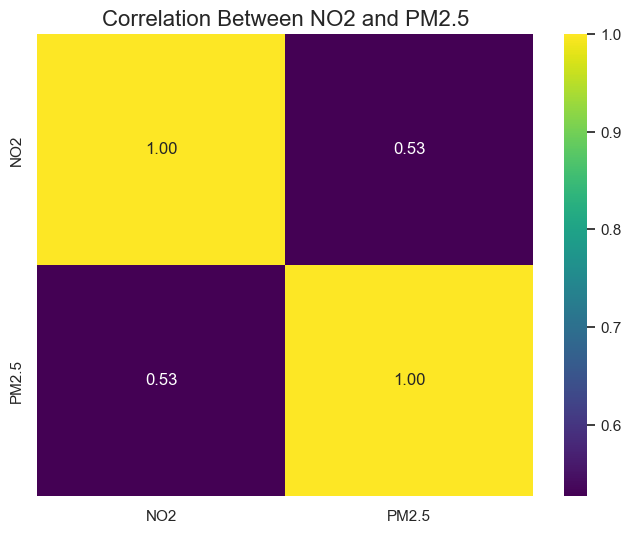

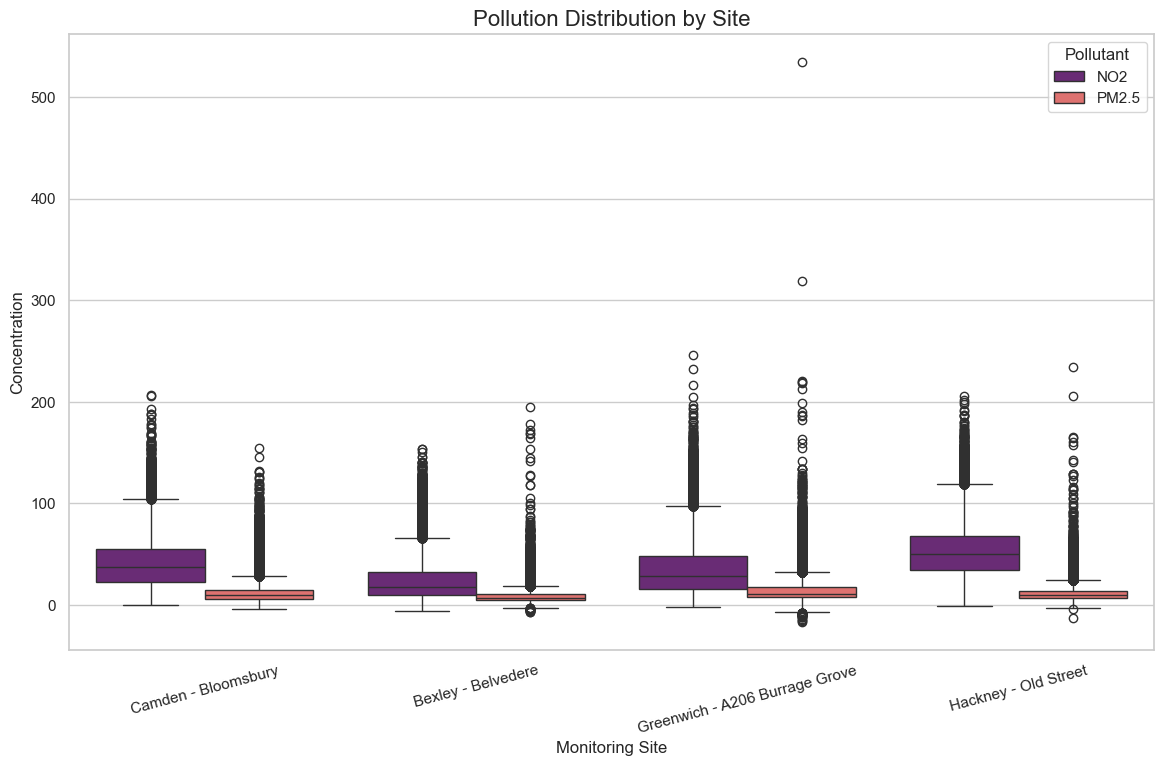

In [40]:
# Correlation and Distribution Analysis
# Correlation Heatmap
correlation_matrix = df[['NO2', 'PM2.5']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Between NO2 and PM2.5', fontsize=16)
plt.show()


# Distribution Plot
plt.figure(figsize=(14, 8))

# "melt" the dataframe to make it easy to plot with seaborn
df_melted = df.melt(id_vars=['site_name'], value_vars=['NO2', 'PM2.5'], var_name='Pollutant', value_name='Concentration')

sns.boxplot(data=df_melted, x='site_name', y='Concentration', hue='Pollutant', palette='magma')
plt.title('Pollution Distribution by Site', fontsize=16)
plt.xlabel('Monitoring Site')
plt.ylabel('Concentration')
plt.xticks(rotation=15)
plt.show()

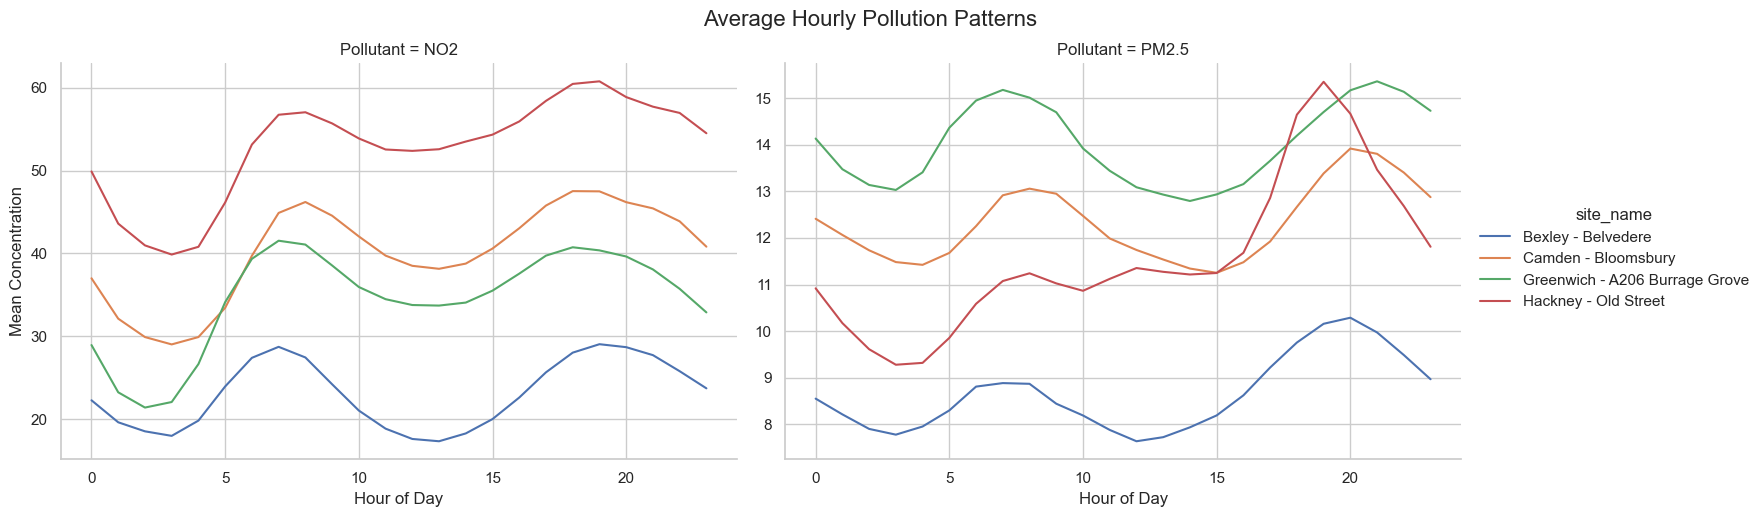

In [41]:
# Hourly Pollution Patterns

# Make a copy to avoid modifying the original df
df_patterns = df.copy()

df_patterns['hour'] = df_patterns.index.hour

# Prepare the data for plotting both pollutants
df_melted = df_patterns.melt(id_vars=['site_name', 'hour'], value_vars=['NO2', 'PM2.5'],
                             var_name='Pollutant', value_name='Concentration')

# Group by hour, site, and pollutant to get the mean
hourly_avg = df_melted.groupby(['hour', 'site_name', 'Pollutant'])['Concentration'].mean().reset_index()

# Plot the results
g = sns.relplot(data=hourly_avg, x='hour', y='Concentration', hue='site_name', col='Pollutant',
                kind='line', facet_kws={'sharey': False}, legend='full', aspect=1.5)

g.fig.suptitle('Average Hourly Pollution Patterns', y=1.03, fontsize=16)
g.set_axis_labels("Hour of Day", "Mean Concentration")
plt.show()

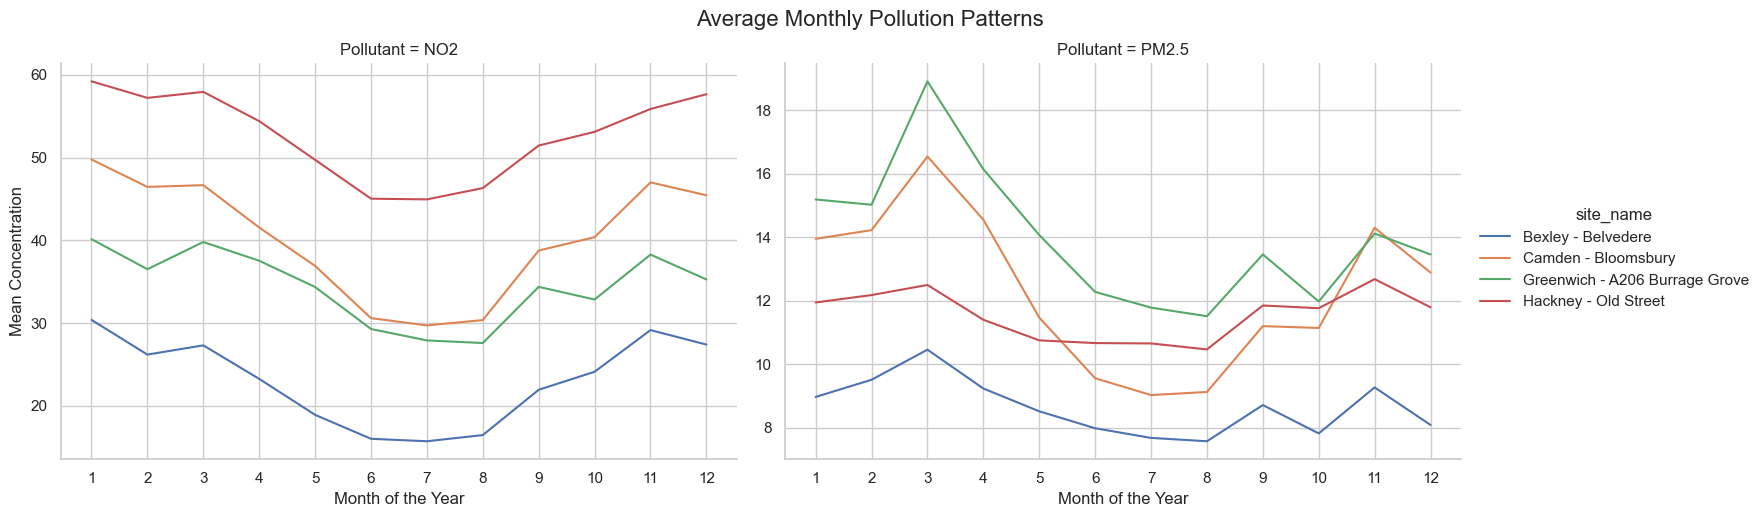

In [42]:
# Monthly Pollution Patterns

# Extract the month
df_patterns['month'] = df_patterns.index.month

# Prepare the data for plotting
df_melted = df_patterns.melt(id_vars=['site_name', 'month'], value_vars=['NO2', 'PM2.5'],
                             var_name='Pollutant', value_name='Concentration')

# Group by month, site, and pollutant to get the mean
monthly_avg = df_melted.groupby(['month', 'site_name', 'Pollutant'])['Concentration'].mean().reset_index()

# Plot the results
g = sns.relplot(data=monthly_avg, x='month', y='Concentration', hue='site_name', col='Pollutant',
                kind='line', facet_kws={'sharey': False}, legend='full', aspect=1.5)

g.fig.suptitle('Average Monthly Pollution Patterns', y=1.03, fontsize=16)
g.set_axis_labels("Month of the Year", "Mean Concentration")
g.set(xticks=range(1, 13)) # Set x-ticks to be 1 to 12
plt.show()

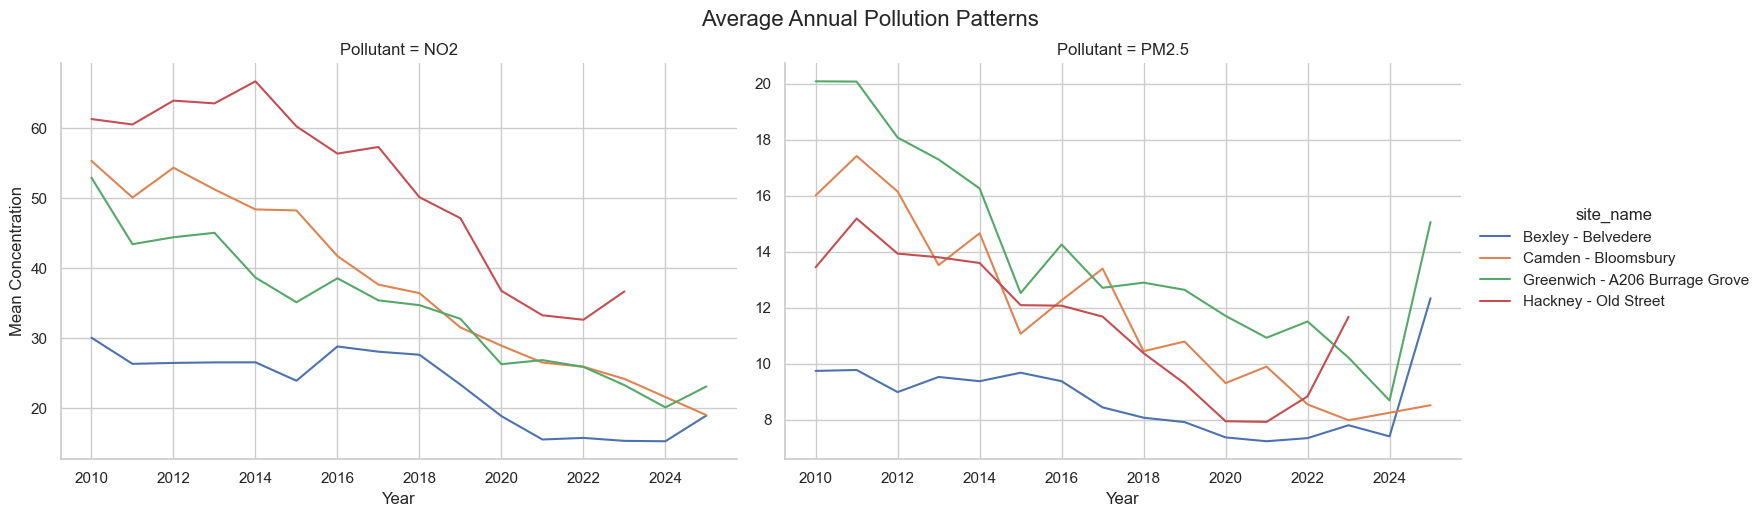

In [44]:
# Annual Pollution Patterns

# Extract the year
df_patterns['year'] = df_patterns.index.year

# Prepare the data for plotting
df_melted = df_patterns.melt(id_vars=['site_name', 'year'], value_vars=['NO2', 'PM2.5'],
                             var_name='Pollutant', value_name='Concentration')

# Group by year, site, and pollutant to get the mean
annual_avg = df_melted.groupby(['year', 'site_name', 'Pollutant'])['Concentration'].mean().reset_index()

# Plot the results
g = sns.relplot(data=annual_avg, x='year', y='Concentration', hue='site_name', col='Pollutant',
                kind='line', facet_kws={'sharey': False}, legend='full', aspect=1.5)

g.fig.suptitle('Average Annual Pollution Patterns', y=1.03, fontsize=16)
g.set_axis_labels("Year", "Mean Concentration")
plt.show()